<b>
  <h1 align=center>The Effect of Farm Operation Costs on Net Profit</h1>
  <h3 align=center>Jayson Carboo</h3>
</b>

# Introduction

There are many costs associated with farming, and these costs can greatly impact how well a farm runs, and how much it can produce yearly. However, a farmer's money is not infinite, and it's important for them to manage spending so they can earn a livable wage. Furthermore, prices for costs all around are [drastically increasing](https://www.agriculturedive.com/news/farm-production-costs-soar-2022-usda/689722/#:~:text=Average%20cost%20per%20farm%20increased,of%20total%20costs%20in%202022.), which is making it even more important for farmers to more efficiently spend their money. This raises the question: what exaclty does it mean to spend efficiently?

Is it to cut costs and minimize how much you spend as possible? One could think this could be the case, but what if spending on something could actually increase your profit? If this is the case, then cutting costs might actually harm your yearly profit, and put you in a worse situation. So how exactly do farmers need to spend their money to get the most bang for their buck? We have now reached the most important part of data analysis: finding a question to solve.



### Hypothesis

Within this analysis, we will seek to identify what are the most important costs for a farmer. To be more specific, which costs have the most impact on how much a farmer can make? To do this we will need to go through the whole data science pipeline, starting from data collection all the way to drawing conclusions from what we found.

This topic is importatant due to how important produce is for national food security. If farmers have lower profits, they have less money to work with for the less year, which could lead to less yield. Optimizing spending could ensure that less areas have food shortages, which means less families hungry, and overall a healthier world

# Part 1: Data Collection and Cleaning

The first step is to import several important libraries we can use to analyze and model our data.

In [79]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model
from texttable import Texttable
import seaborn as sns
import matplotlib.pyplot as plt

##### **Data Source**
The data we are using is from the [USDA](https://www.ers.usda.gov/data-products/commodity-costs-and-returns/commodity-costs-and-returns/) It contains information on costs and returns for a multitude of crops, but we will specifically be analyzing corn. The first step is to download the data into a data frame. The data from the usda is formatted as an xml file, but be converted to a csv by any online tool.

In [80]:
data = pd.read_csv("CornCostReturn.csv")
op_data = data[data['Category'] == 'Operating costs']
val_data = data[data['Category'] == 'Net value']

We have isolated the categories that we want from the data: Operating costs, and net value. The categories for oeprating costs are:
Seed
Fertilizer  
Chemicals
Custom services  
Fuel, lube, and electricity
Repairs
Purchased irrigation water
Interest on operating capital
Total, operating costs

However, there are sections of the data set we don't need, so we need to get rid of them to make our data easier to use and model later on.

In [81]:

# Reason for removing each column:
# Item2 - For our purposes each item in Item column is the same as the value in Item2 column
# Note - No special notes exist for the Operating Cost Category
# Country - All are the same country (USA)
# Size - No Specific Size for each row
op_data = op_data.drop(['Item2', 'Note', 'Country', 'Size'], axis=1)
val_data = val_data.drop(['Item2', 'Note', 'Country', 'Size'], axis=1)

# replacing names to be more straightforward/ remove any formatting errors
op_data['Item'].replace('Fertilizer ¹ ', 'Fertilizer', inplace=True)
op_data['Item'].replace('Custom services ² ', 'Services', inplace=True)
op_data['Item'].replace('Fuel, lube, and electricity', 'FLE', inplace=True)
op_data['Item'].replace('Purchased irrigation water', 'Water', inplace=True)
op_data['Item'].replace('Interest on operating capital', 'Interest', inplace=True)

val_data['Item'].replace('Value of production less operating costs', 'Value', inplace=True)

op_data = op_data[op_data['Item'] != 'Total, operating costs']
op_data = op_data[op_data['Region'] != 'U.S. total']

val_data = val_data[val_data['Item'] != 'Value of production less total costs listed']
val_data = val_data[val_data['Region'] != 'U.S. total']

op_pivot = op_data.pivot_table(index=['Year', 'Region'], columns='Item', values='Value').reset_index()
val_pivot = val_data.pivot_table(index=['Year', 'Region'], columns='Item', values='Value').reset_index()

final_df = pd.merge(op_pivot, val_pivot, on=['Year', 'Region'])
final_df.head(10)

Item,Year,Region,Chemicals,FLE,Fertilizer,Interest,Repairs,Seed,Services,Water,Value
0,1996,Eastern Uplands,31.66,19.11,70.57,3.90,14.66,21.23,6.48,0.00,196.31
1,1996,Heartland,28.57,22.35,54.64,3.87,14.41,27.32,10.75,0.00,224.12
2,1996,Northern Crescent,26.37,20.82,47.85,3.53,14.82,25.10,9.33,0.00,148.92
3,1996,Northern Great Plains,19.15,21.24,27.67,3.29,17.04,25.15,20.98,0.23,133.30
4,1996,Prairie Gateway,26.50,43.17,42.88,4.53,24.12,27.23,14.28,2.40,244.57
5,1996,Southern Seaboard,21.86,19.07,68.94,3.84,16.60,22.04,12.37,0.00,171.12
6,1997,Eastern Uplands,30.31,17.56,68.04,3.85,14.51,22.07,6.37,0.00,114.73
7,1997,Heartland,27.97,22.16,54.02,3.95,14.64,29.39,10.58,0.00,179.02
8,1997,Northern Crescent,26.04,21.90,45.92,3.66,15.56,27.63,9.88,0.00,164.77
9,1997,Northern Great Plains,19.00,20.95,26.89,3.41,17.55,27.59,21.34,0.25,95.10


We change some category names to make them easier to write, as well as prevent any errors from the syntax of the data. Once we have the cleaned costs data and cleaned value data, we need to merge the data sets to

# Part 2: Visualizations

Now that we have our data frame, lets take a preliminary look at our costs. First, lets make a correlation matrix to see the correlation between each operation costs. We can do this by making a heat map for correlation, with higher correlations leaning more towards red, and lower correlations leading more towards blue.

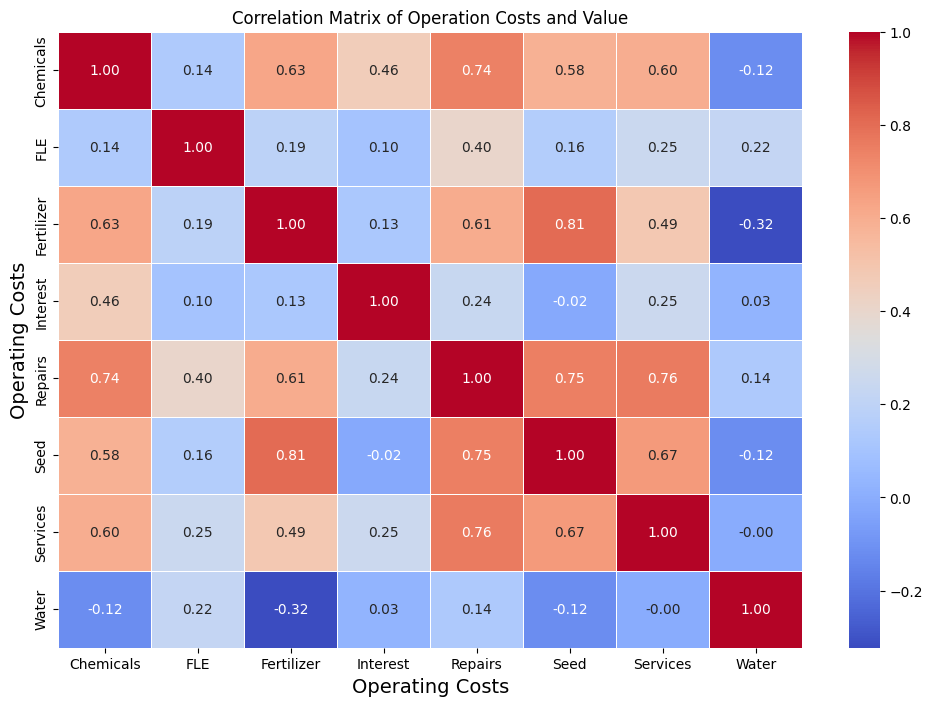

In [82]:
viz_relevant_features = final_df[['Chemicals', 'FLE', 'Fertilizer', 'Interest',
                     'Repairs', 'Seed', 'Services', 'Water']]
corr = viz_relevant_features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix of Operation Costs and Value')
plt.xlabel('Operating Costs', fontsize=14)
plt.ylabel('Operating Costs', fontsize=14)
plt.show()

Obviously costs would have a 1-to-1 correlation with themselves, but lets take a look at things with relatively higher correlations. The highest noticeable correlation is seed and fertilizer. We can view this as needing to buy a certain amount of fertilizer based on how many seeds you buy to plant, which is sensible. Another is repairs and services, which could be due to the costs of ordering repairs being aligned with purchasing custom services.

Another way to look at the data would be to make a box plot for each operating cost. A box plot can give us simple, yet useful data about a variable, such as its mean, meadian, as well as the variation ebtween its upper and lower quartiles.

<ipython-input-83-c46b33e067e7>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)
<ipython-input-83-c46b33e067e7>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)


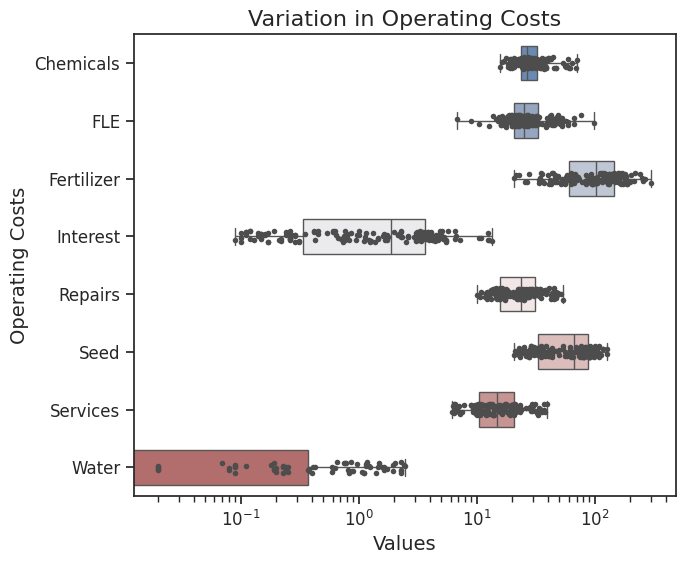

In [83]:
sns.set_theme(style="ticks")

# Melt the DataFrame to long format for seaborn boxplot
cost_columns = ['Chemicals', 'FLE', 'Fertilizer', 'Interest', 'Repairs', 'Seed', 'Services', 'Water']
df_melted = pd.melt(final_df, id_vars=['Year', 'Region'], value_vars=cost_columns)
df_melted.head(10)

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Draw the horizontal box plot
boxplot = sns.boxplot(x='value', y='Item', data=df_melted, palette='vlag', hue='Item', orient='h', whis=[0,100], width=.6)

# Add in points to show each observation
sns.stripplot(df_melted, x="value", y="Item", size=4, color=".3")

# Customize the axis text
boxplot.set_yticklabels(boxplot.get_yticklabels(), fontsize=12)
boxplot.set_xticklabels(boxplot.get_xticklabels(), fontsize=12)

# Add title and labels
plt.title('Variation in Operating Costs', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Operating Costs', fontsize=14)

plt.show()

Most of the operating costs have relatively evenly split data, with values spanning the whole plot. The ones that stick out the most are interest and water, as they have the highest distributions of data. Interest has data that is more spread out toward the lower end, and water seems to have a very weird skew, with most of the data points lying on the right whisker. There is seemingly no left whisker, which means that the lowest values lie around the 1st quartile. Purchases for water are weird because, depending on the region, a farmer might barely need to spend for irrigation. If there are little to no natural sources of water around the farm, they would need to spend a lot more on irrigation.

Let's get a more direct view of how our operating costs interact with profit using a scatter plot. Scatterplots will show us what profit was associated with each value of an operating cost.

<Figure size 2000x800 with 0 Axes>

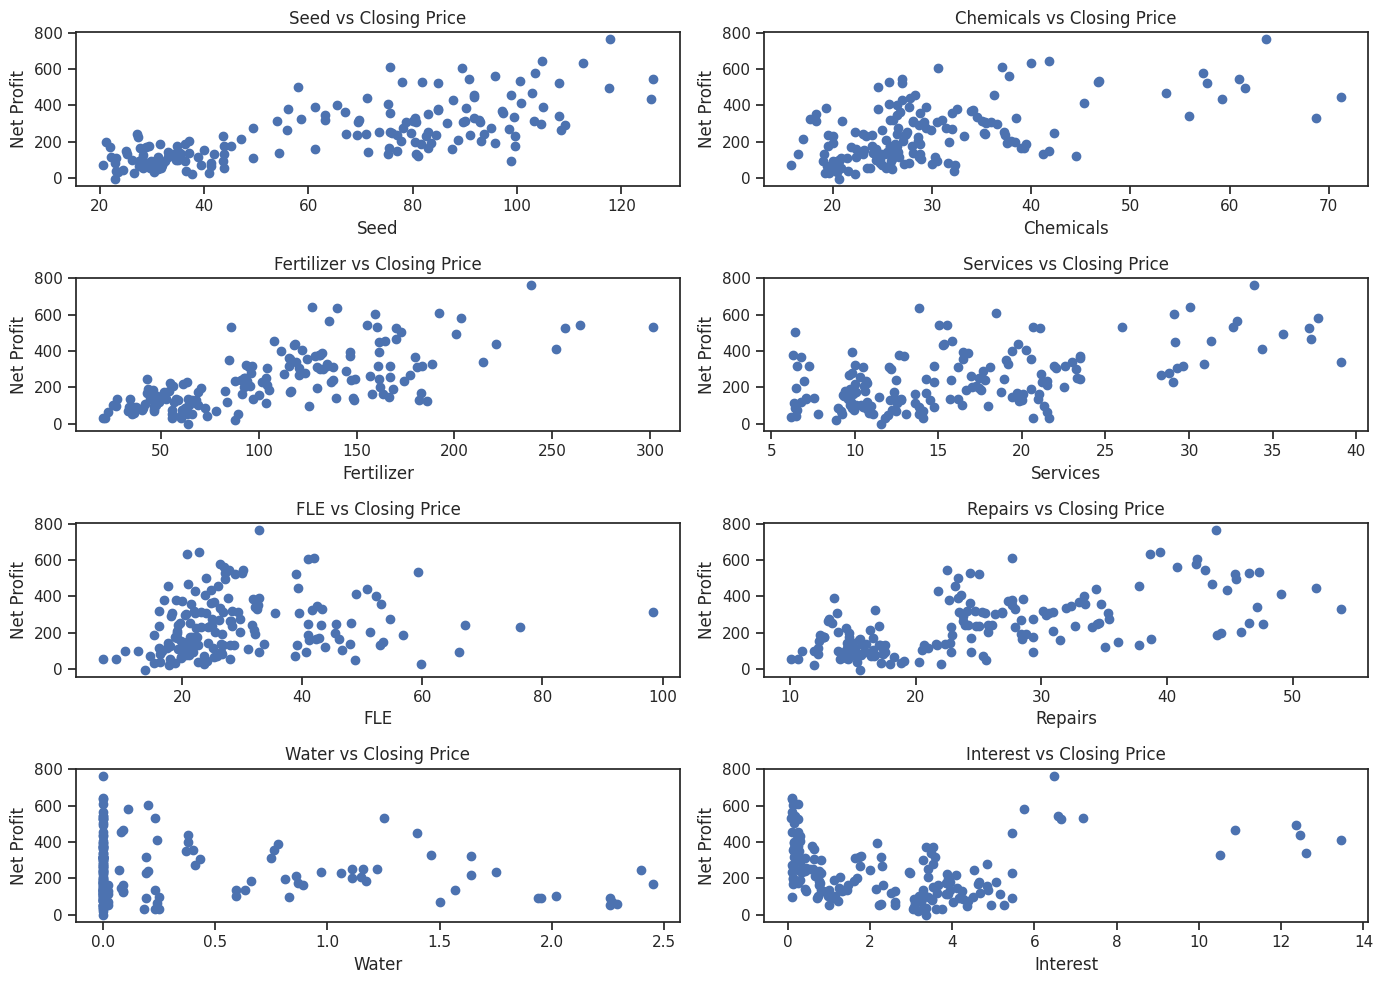

In [84]:
# Create subplots for detailed relationships
plt.figure(figsize=(20, 8))

fig, axs = plt.subplots(4, 2, figsize=(14, 10))

# Plot highest price vs closing price
axs[0, 0].scatter(final_df['Seed'], final_df['Value'])
axs[0, 0].set_xlabel('Seed')
axs[0, 0].set_ylabel('Net Profit')
axs[0, 0].set_title('Seed vs Closing Price')

# Plot low price vs closing price
axs[0, 1].scatter(final_df['Chemicals'], final_df['Value'])
axs[0, 1].set_xlabel('Chemicals')
axs[0, 1].set_ylabel('Net Profit')
axs[0, 1].set_title('Chemicals vs Closing Price')

# Plot opening price vs closing price
axs[1, 0].scatter(final_df['Fertilizer'], final_df['Value'])
axs[1, 0].set_xlabel('Fertilizer')
axs[1, 0].set_ylabel('Net Profit')
axs[1, 0].set_title('Fertilizer vs Closing Price')

# Plot opening price vs closing price
axs[1, 1].scatter(final_df['Services'], final_df['Value'])
axs[1, 1].set_xlabel('Services')
axs[1, 1].set_ylabel('Net Profit')
axs[1, 1].set_title('Services vs Closing Price')

# Plot opening price vs closing price
axs[2, 0].scatter(final_df['FLE'], final_df['Value'])
axs[2, 0].set_xlabel('FLE')
axs[2, 0].set_ylabel('Net Profit')
axs[2, 0].set_title('FLE vs Closing Price')

# Plot opening price vs closing price
axs[2, 1].scatter(final_df['Repairs'], final_df['Value'])
axs[2, 1].set_xlabel('Repairs')
axs[2, 1].set_ylabel('Net Profit')
axs[2, 1].set_title('Repairs vs Closing Price')

# Plot opening price vs closing price
axs[3, 0].scatter(final_df['Water'], final_df['Value'])
axs[3, 0].set_xlabel('Water')
axs[3, 0].set_ylabel('Net Profit')
axs[3, 0].set_title('Water vs Closing Price')

# Plot opening price vs closing price
axs[3, 1].scatter(final_df['Interest'], final_df['Value'])
axs[3, 1].set_xlabel('Interest')
axs[3, 1].set_ylabel('Net Profit')
axs[3, 1].set_title('Interest vs Closing Price')

plt.tight_layout()
plt.show()

Taking a look at the scatter plots, we can see that only 3 seem to have a positive correlation with net profit: seed, chemicals, and fertilizer. Water and interest, interestingly have a large amount of zero values, which could be dependent on if a farmer was in a region with abundant water, or if the farmer didn't need to take out any loans. The rest of variables seemingly have slightly positive, or little to no correlation with profit.

## Part 4: Model Implementation

I have collected, cleaned, and explored our data. The next step in the data science pipeline would be to create a model that attempts to find a correlation between this data. There are many different ways to find correlations between data, but you should choose a model type that best matches what you aim to find from your data. For my data, I chose to use a gradient descent algorithm. To understand what a gradient descent algorithm is, it is important to understand what the term "gradient" means. A [gradient](https://builtin.com/data-science/gradient-descent) can broadly be defined as the direction of change. An easy way to perceive a gradient is to think of the slope of a function like a line. In the context of the Gradient Descent algorithm, a gradient measures how the input of a fucntion changes if you change the inputs. This can be used in machine learning to find the coefficient parameters for the independent variable, in this case operation costs, of our function that will minimize the dependent variable, in this case value of production for corn. Below is the gradient descent algorithm used for this model:

In [85]:
# Define gradient descent algorithm
def grad_descent(X, y, T, alpha):
    m, n = X.shape  # m = #examples, n = #features
    theta = np.zeros(n, dtype=float)  # initialize parameters as floats
    f = np.zeros(T)  # track loss over time
    for i in range(T):
        # loss for current parameter vector theta
        f[i] = 0.5 * np.linalg.norm(np.dot(X, theta) - y) ** 2
        g = np.dot(X.T, np.dot(X, theta) - y)
        # step down the gradient
        theta = theta - alpha * g
    return theta, f

X and y are our independent and dependent variable respectively, T is the number of iterations our algorithm goes through, and alpha is the learning rate of our algorithm. You can think of alpha as the "size" of the steps our algorithm takes. Next, we initialize the parameters and run the gradient descent algorithm.

In [86]:
# Extract independent and dependent variables
X_train = final_df[["Seed", "Fertilizer", "Chemicals", "Services", "FLE", "Repairs", "Water", "Interest"]].values.astype(float)
y_train = final_df["Value"].values.astype(float)

# Normalize the features
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)

# Add bias term to the independent variables
X_train = np.c_[np.ones(X_train.shape[0]), X_train]

# Set hyperparameters
T = 1000  # Number of iterations
alpha = 0.001  # Learning rate

# Train the model using gradient descent
weights, loss_history = grad_descent(X_train, y_train, T, alpha)


Notice the values used for T and alpha. These aren't set valuables that work with every data set, but values I chose for this data set in particular. When performing this algorithm on a data set, it is necessary to find a combination that will yield the msot accurae results. Your learning rate has to be slow enough for the model to actually learn, but not too slow that the model won't work well. You also need to find a value for the number of iterations, T, that will allow the model to yield accurate results. You can keep increasing T and decreasing alpha until the results stabilize, usually by factors of 10.

In [87]:
# List out weights and bias
print("Weights: ", weights)

Bias = weights[0]
Seed_C = weights[1];
Fertilizer_C = weights[2];
Chemicals = weights[3];
Services = weights[4];
FLE = weights[5];
Repairs = weights[6];
Water = weights[7];
Interest = weights[8];

Weights:  [239.7464881   39.43401255  49.89253847  26.69085134  20.68998737
  -0.48757241   7.81974423   1.39961518 -26.77595664]


Now what exactly do these values mean? The bias term can be thought of as the y-intercept of the data, which means it essentially shifts the value obtained from multiplying the weights with the features. Each weight associated with the features can be thought of as a correlation value between the feature and the net profit. Features farther away from 0 have a higher correlation, and features closer to zero have a lower correlation. For example, lets look at the weight for fertlizer vs the weight for repairs. The high weight for fertlizer vs the relatively lower weight for repairs means that spending more on fertilizerm yieled a higher net profit for farmers than spending on repairs. In the context, it makes sense for fertilizer to have a high correlation to net profit, as fertilizer directly impacts crop growth and crop yield, whereas repairs don't have as much of a direct impact on production. Now lets look at the weight associated with interest. Notice that this weight is negative, confusing right? A negative weight simply means an inverse correlation between the feature and net profit. The [interest](https://www.farmop.com/farmop-capital/2022/3/23/what-does-your-farms-annual-operating-loan-actually-cost) on operating costs is a value that does not benefit the farm at all, in fact it does the opposite. Interest on loans is just extra loss, and does not directly help the farm produce more, which is representative of the negative weight value. Now let's make a function to simply calculate a predicted net value based on these weights.


In [88]:
def calculate_net(weights, features):
    # Convert inputs to numpy arrays for easier manipulation

    weights = np.array(weights)
    features = np.array(features)

    bias_term = weights[0]
    weights = weights[1:]
    # Calculate the weighted sum of the features
    weighted_sum = np.dot(features, weights)

    # Calculate the cost by adding the bias term to the weighted sum
    net = bias_term + weighted_sum

    return net

Mean Squared Error (MSE): 98719531.8562405


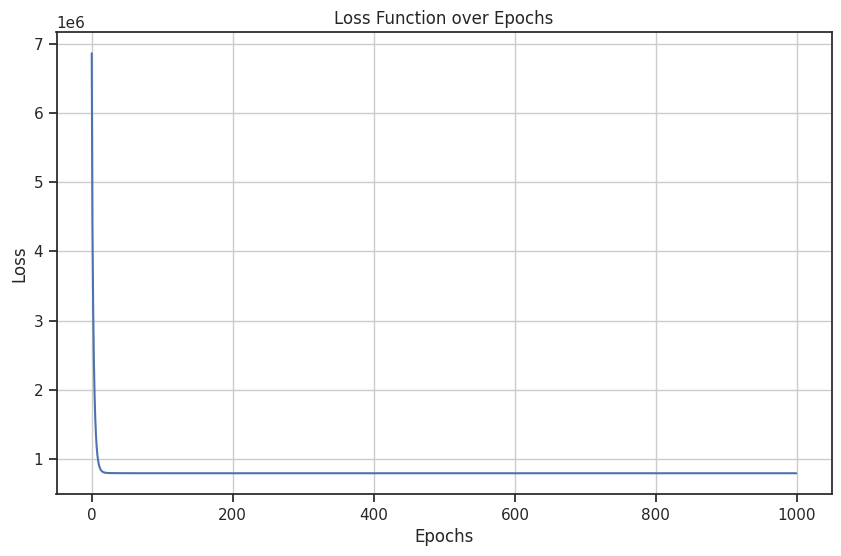

In [89]:
# Use learned weights and bias to predict profit for each day in the test set
X_test = final_df[["Seed", "Fertilizer", "Chemicals", "Services", "FLE", "Repairs", "Water", "Interest"]].values.astype(float)
y_train = final_df["Value"].values.astype(float)

# Predict net profit
predicted_values = calculate_net(weights, X_test)

# Calculate Mean Squared Error (MSE)
mse = np.mean((predicted_values - y_train) ** 2)
print("Mean Squared Error (MSE):", mse)


plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.grid(True)
plt.show()



This graph represents how much better the model got through each iteration (epoch). Loss represents the difference between the predicted output and the actual output, in our case the net profit. Our [mean squared error](https://encord.com/glossary/mean-square-error-mse/), which represents the average squareed difference of our predicted vs actual values, was a wopping 98 million, which is a lot higher than we'd like. Lets take a look at a scatter plot of our predicted vs actual values, to get a better idea of how our predicted values look.

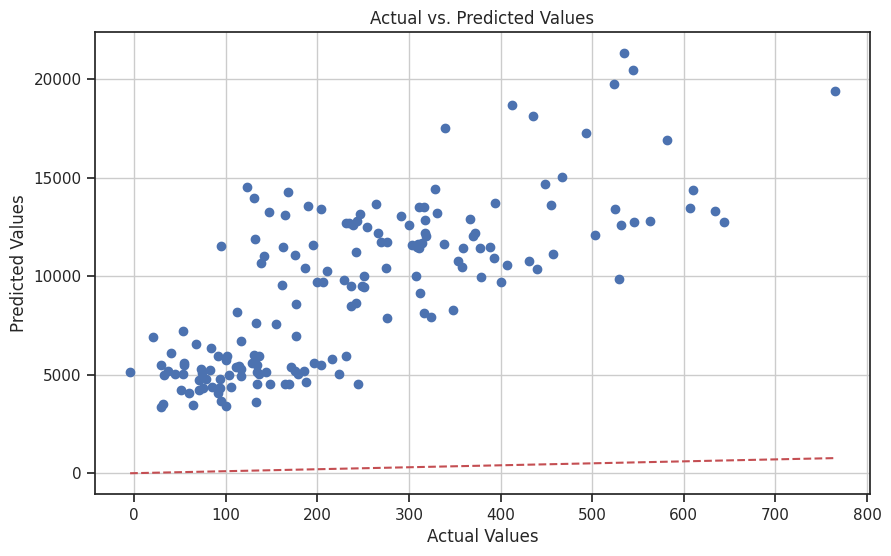

In [90]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')  # line y=x
plt.grid(True)
plt.show()

The red dotted line represents the line of perfect predictions, or simply y=x. We can gauge how accurate our model is by how the points of predicted vs actual fit on the line. No points lie on the line, which means our model is incredibly inaccurate. However, This does not necesarily mean the weights we obtained are wrong, as they still represent the features correlation with the net profit, it just means that there is overfitting in our data, or values that stray so far from the correlation that it messes up our mdoel's learning. We can try to fix this through normalizing the data. Normalizing the data essentially scales brings all the data points to a similar scale. It does this by subtracting the mean and dividing it by the standard deviation. Normalziing the data ensures that no one feature overpowers the others during the learning process.

Mean Squared Error (MSE): 9408.540586400442


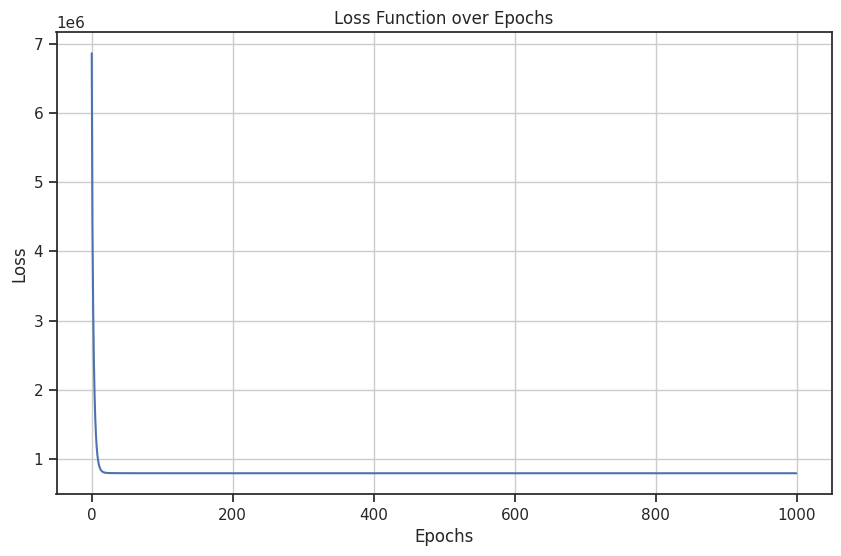

In [91]:
# Use learned weights and bias to predict profit for each day in the test set
X_test = final_df[["Seed", "Fertilizer", "Chemicals", "Services", "FLE", "Repairs", "Water", "Interest"]].values.astype(float)
X_test_norm = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_train = final_df["Value"].values.astype(float)

# Predict profit
predicted_values_norm = calculate_net(weights, X_test_norm)

# Calculate Mean Squared Error (MSE)
mse = np.mean((predicted_values_norm - y_train) ** 2)
print("Mean Squared Error (MSE):", mse)


plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.grid(True)
plt.show()

We can see that the mean squared error drastically decreased once we normalized the data, meaning our model predictions are way more accurate and close to the actual values. Lets take a look at the update scatter plot:

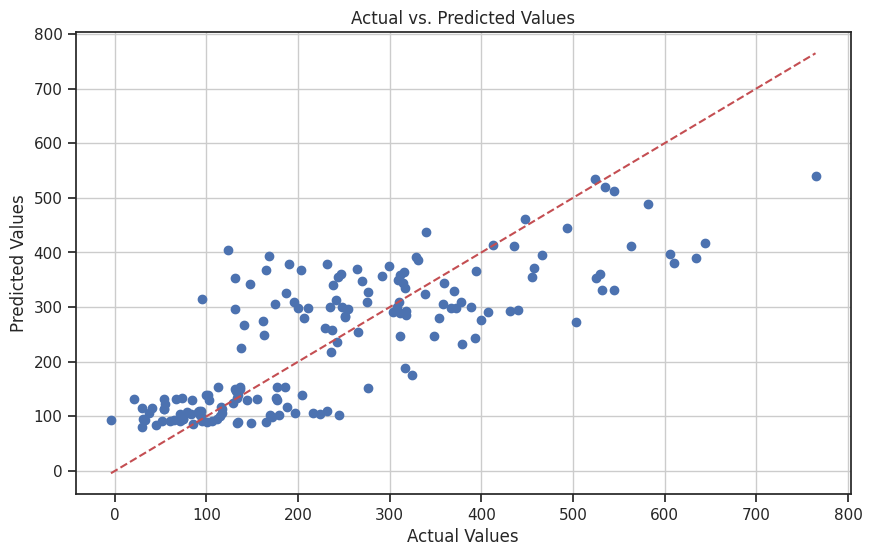

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, predicted_values_norm)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')  # line y=x
plt.grid(True)
plt.show()

## Interpretation and Insight

At this stage of the data science pipeline, we take the data we received from our ML model and try to reach a conclusion with it. The weights we obtained for each cost are as follows:

In [93]:
t = Texttable()
weight_list = [['Cost', 'Weight'], ['Seed', Seed_C], ['Fertilizer', Fertilizer_C], ['Chemicals', Chemicals], ['Customer Services', Services], ['Fuel, Lube, Electricity', FLE], ['Repairs', Repairs], ['Purchased Irrigation Water', Water], ['Interest on operating capital', Interest]]
t.add_rows(weight_list)
print(t.draw())

+-------------------------------+---------+
|             Cost              | Weight  |
+===============================+=========+
| Seed                          | 39.434  |
+-------------------------------+---------+
| Fertilizer                    | 49.893  |
+-------------------------------+---------+
| Chemicals                     | 26.691  |
+-------------------------------+---------+
| Customer Services             | 20.690  |
+-------------------------------+---------+
| Fuel, Lube, Electricity       | -0.488  |
+-------------------------------+---------+
| Repairs                       | 7.820   |
+-------------------------------+---------+
| Purchased Irrigation Water    | 1.400   |
+-------------------------------+---------+
| Interest on operating capital | -26.776 |
+-------------------------------+---------+


The highest valued weights we see are fertilizer and seed costs, with weights 49.9 and 39.4 respectively. This means that spending more on those costs yields the most return in terms of net profit for corn. This makes sense, as the amount of profit you can get is directly impacted by how many seeds you buy, and fertilizer is a staple product in growing produce. The values closest to 0 are fuel, lube, and electricity, as well as irrigation water. This means that compared to other values, they have relatively little to no impact on profit. We see fuel, lube, and electricity have a slightly negative value, which is representative of the [growing energy costs](https://extension.umd.edu/resource/understanding-farm-energy-fs-1138/) on farms. Although they have little to no effect, this could change in the near future as energy becomes more and more expensive. The lowest value shown is interest on operating capital. This is because interest is a form of extra cost based on how much a farmer has spent for loans, meaning it directly amplifies loss, yielding a lower net profit.

### Potential uses of model

With this model, producers can attempt to calculate their current net profit any time in the year by inputting their current costs. They can also use this model to see how the net profit would change by investing money in different categories, which can guide them in how to more efficiently use their money. It is important to note that this model was only trained on **corn** data. This means that the weights are only really representive of costs and net value for corn, and should **NOT** be though of as a perfect model for every time of produce. However, this model can easily be replicated with different produce, by simply switching the dataset found from the [USDA](https://www.ers.usda.gov/data-products/commodity-costs-and-returns/commodity-costs-and-returns/). For example, this model could be replicated with cotton, peanuts, milk, etc.

### Final Notes

The model can somewhat accurately predict the net profit from different costs, but this could easily change depending on future data. For example, as stated earlier growing energy costs could decrease the weight of fuel, lube, and electricity, making it have a higher negative impact on net profit. Global warming could potentially cause droughts in some areas, making it necessary to purchase more irrigation water which could greatly change it's weight. It is important to not solely rely on this tool to optimize costs, but use it as a guide along with research on the current situation surrounding said cost.